In [135]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
from collections import defaultdict
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision

import torch.nn.functional as F



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
    ]) 
    return transform(image).unsqueeze(0)

def get_indexes(arr, value):
    indexes = []
    for i in range(len(arr)):
        if arr[i] == value:
            indexes.append(i)
    return indexes

def get_length_per_class(dataloader, classes):
    class_counts = defaultdict(int)
    total = 0
    for batch in dataloader:
        _, labels = batch 
        labels = labels.numpy().tolist()
        for label in labels:
            class_counts[label] += 1
            total +=1

    class_counts = dict(sorted(class_counts.items()))
    for class_label, count in class_counts.items():
        print(f"Class {classes[class_label]}: {count} samples out of {total}")
def load_data(data_dir,
                           batch_size,
                           data_type,
                           noise_type,
                           noise_percentage,                           
                           transform,                           
                           data_percentage=1,
                           show_classes = False, random_seed=21):
    
    if noise_type == "None":
        noise_type = ""
        noise_percentage = ""
    else:
        noise_type = "/" + str(noise_type)
        noise_percentage = "/" + str(noise_percentage)
    path = data_dir + noise_type + "/" + data_type + noise_percentage
    print("path: ", path)
    dataset = ImageFolder(root=path, transform=transform)
    original_classes = dataset.classes 
    num_samples = len(dataset)
    indices = list(range(num_samples))

    labels = dataset.targets
    class_to_idx = dataset.class_to_idx
    needed_length = int(num_samples*data_percentage/100)
    expected_length_per_class = int(needed_length/len(original_classes))
    print(f"needed_length: {needed_length}, expected_length_per_class: {expected_length_per_class}")
    if data_percentage != 100:
        new_indices = []
        for key, value in class_to_idx.items():
            all_indixes_of_class = get_indexes(labels, value)
            new_indices.extend(all_indixes_of_class[:expected_length_per_class])
    else:
        new_indices = indices
    length_dataset = len(new_indices)
    print("length of final dataset:", length_dataset)

    
    # sampler = SubsetRandomSampler(new_indices)

    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    if show_classes:
        get_length_per_class(dataloader, original_classes)
        
    random.shuffle(new_indices)

   
    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    return dataloader, length_dataset, original_classes

def testing(model, classes):
    model.eval()
    y_pred1 = torch.tensor([])
    y_target1 = torch.tensor([])
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(len(classes))]
        n_class_samples = [0 for _ in range(len(classes))]
        n_class_true_positives = [0 for _ in range(len(classes))]
        n_class_predicted_positives = [0 for _ in range(len(classes))]
        n_class_false_positives = [0 for _ in range(len(classes))]
        n_class_false_negatives = [0 for _ in range(len(classes))]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
             
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            y_pred1 = torch.cat((labels, y_pred1), dim=0)
            y_target1 = torch.cat((predicted, y_target1), dim=0)
            
            for i in range(len(images)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class_false_positives[label] += 1 if int(pred != label) else 0
                n_class_true_positives[pred] += int(pred == label)
                n_class_false_negatives[pred] += 1 if int(pred != label) else 0
                

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        recall_arr = []
        precision_arr = []
        f_score_arr = []

        for i in range(len(classes)):
            precision = n_class_true_positives[i] / (n_class_true_positives[i] + n_class_false_positives[i])
            recall = n_class_true_positives[i] / (n_class_true_positives[i] + n_class_false_negatives[i])
            f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            recall_arr.append(round(recall, 4))
            precision_arr.append(round(precision, 4))
            f_score_arr.append(round(f_score, 4))
            
            print(f'Class: {classes[i]}')
            print(f'Accuracy: {100.0 * n_class_correct[i] / n_class_samples[i]} %')
            print('---')
        mcr = MulticlassRecall(num_classes=len(classes), average=None)
        mcp = MulticlassPrecision(num_classes=len(classes), average=None)

        print(mcr(y_pred1, y_target1))
        print(recall_arr)

        print(mcp(y_pred1, y_target1))
        print(precision_arr)
        print(f_score_arr)


print('ready')

ready


In [131]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
])   

noise_type = "gaussian_noise"
noise_percentage = 10
data_percentage = 100
total_size = 21000

train_size = data_percentage*total_size/100
data_dir = '../data/vegetable_images'

train_loader, train_size, classes = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "train",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader, valid_size, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader_with_noise, _, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = noise_type,
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataloaders = {'train':  train_loader, 
               'val': valid_loader
               }
dataloaders_with_noise = {'train':  train_loader, 
               'val': valid_loader_with_noise
               }


test_loader,test_size_, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)


test_loader_without_noise, _, _ = load_data(data_dir =data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataset_sizes = {'train':  train_size, 
        'val': valid_size,
        'test': test_size_
       }




path:  ../data/vegetable_images/train
needed_length: 15000, expected_length_per_class: 1000
length of final dataset: 15000
path:  ../data/vegetable_images/validation
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/validation/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/test/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/test
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000


# TESTING ON THE IMAGES WITH 10% NOISE

In [117]:
alexnet = torch.load('../models/alexnet_without_noise.pth', map_location=torch.device('cpu'))
testing(alexnet, classes)

Accuracy of the network: 96.13333333333334 %
Class: Bean
Accuracy: 96.5 %
Precision: 0.9948453608247423
Recall: 0.965
F-score: 0.9796954314720813
---
Class: Bitter_Gourd
Accuracy: 99.0 %
Precision: 1.0
Recall: 0.99
F-score: 0.9949748743718593
---
Class: Bottle_Gourd
Accuracy: 96.0 %
Precision: 0.9896907216494846
Recall: 0.96
F-score: 0.9746192893401014
---
Class: Brinjal
Accuracy: 89.0 %
Precision: 0.9834254143646409
Recall: 0.89
F-score: 0.9343832020997376
---
Class: Broccoli
Accuracy: 99.5 %
Precision: 0.9900497512437811
Recall: 0.995
F-score: 0.9925187032418954
---
Class: Cabbage
Accuracy: 99.0 %
Precision: 0.9850746268656716
Recall: 0.99
F-score: 0.9875311720698254
---
Class: Capsicum
Accuracy: 74.5 %
Precision: 1.0
Recall: 0.745
F-score: 0.8538681948424068
---
Class: Carrot
Accuracy: 99.5 %
Precision: 0.9900497512437811
Recall: 0.995
F-score: 0.9925187032418954
---
Class: Cauliflower
Accuracy: 98.0 %
Precision: 0.9949238578680203
Recall: 0.98
F-score: 0.9874055415617129
---
Class:

In [136]:
alexnet = torch.load('../models/alexnet_without_noise.pth', map_location=torch.device('cpu'))
testing(alexnet, classes)

Accuracy of the network: 96.13333333333334 %
Class: Bean
Accuracy: 96.5 %
---
Class: Bitter_Gourd
Accuracy: 99.0 %
---
Class: Bottle_Gourd
Accuracy: 96.0 %
---
Class: Brinjal
Accuracy: 89.0 %
---
Class: Broccoli
Accuracy: 99.5 %
---
Class: Cabbage
Accuracy: 99.0 %
---
Class: Capsicum
Accuracy: 74.5 %
---
Class: Carrot
Accuracy: 99.5 %
---
Class: Cauliflower
Accuracy: 98.0 %
---
Class: Cucumber
Accuracy: 98.5 %
---
Class: Papaya
Accuracy: 98.5 %
---
Class: Potato
Accuracy: 100.0 %
---
Class: Pumpkin
Accuracy: 100.0 %
---
Class: Radish
Accuracy: 100.0 %
---
Class: Tomato
Accuracy: 94.0 %
---
tensor([0.9948, 1.0000, 0.9897, 0.9834, 0.9900, 0.9851, 1.0000, 0.9900, 0.9949,
        0.8383, 0.8678, 0.8850, 0.9756, 0.9950, 0.9895])
[0.9948, 1.0, 0.9897, 0.9834, 0.99, 0.9851, 1.0, 0.99, 0.9949, 0.8383, 0.8678, 0.885, 0.9756, 0.995, 0.9895]
tensor([0.9650, 0.9900, 0.9600, 0.8900, 0.9950, 0.9900, 0.7450, 0.9950, 0.9800,
        0.9850, 0.9850, 1.0000, 1.0000, 1.0000, 0.9400])
[0.965, 0.99, 0.96, 

In [ ]:
resnet = torch.load('../models/resnet_without_noise.pth', map_location=torch.device('cpu'))
testing(resnet)

Accuracy of the network: 99.2 %
Accuracy of Bean: 100.0 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 100.0 %
Accuracy of Brinjal: 99.5 %
Accuracy of Broccoli: 98.5 %
Accuracy of Cabbage: 99.5 %
Accuracy of Capsicum: 99.5 %
Accuracy of Carrot: 98.5 %
Accuracy of Cauliflower: 98.0 %
Accuracy of Cucumber: 98.0 %


In [ ]:
efficientnet = torch.load('../models/efficientnet_without_noise.pth', map_location=torch.device('cpu'))
testing(efficientnet)

Accuracy of the network: 96.53333333333333 %
Accuracy of Bean: 99.5 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 87.0 %
Accuracy of Brinjal: 98.0 %
Accuracy of Broccoli: 97.0 %
Accuracy of Cabbage: 98.0 %
Accuracy of Capsicum: 97.0 %
Accuracy of Carrot: 97.5 %
Accuracy of Cauliflower: 95.5 %
Accuracy of Cucumber: 96.0 %


In [92]:
vgg16 = torch.load('../models/vgg16_without_noise.pth', map_location=torch.device('cpu'))
testing(vgg16, classes)

Accuracy of the network: 96.3 %
Accuracy of Bean: 100.0 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 87.0 %
Accuracy of Brinjal: 93.5 %
Accuracy of Broccoli: 99.5 %
Accuracy of Cabbage: 99.0 %
Accuracy of Capsicum: 79.5 %
Accuracy of Carrot: 98.5 %
Accuracy of Cauliflower: 95.0 %
Accuracy of Cucumber: 99.0 %
Accuracy of Papaya: 98.0 %
Accuracy of Potato: 100.0 %
Accuracy of Pumpkin: 99.5 %
Accuracy of Radish: 99.5 %
Accuracy of Tomato: 97.5 %


In [105]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

torch.Size([1, 64, 56, 56])


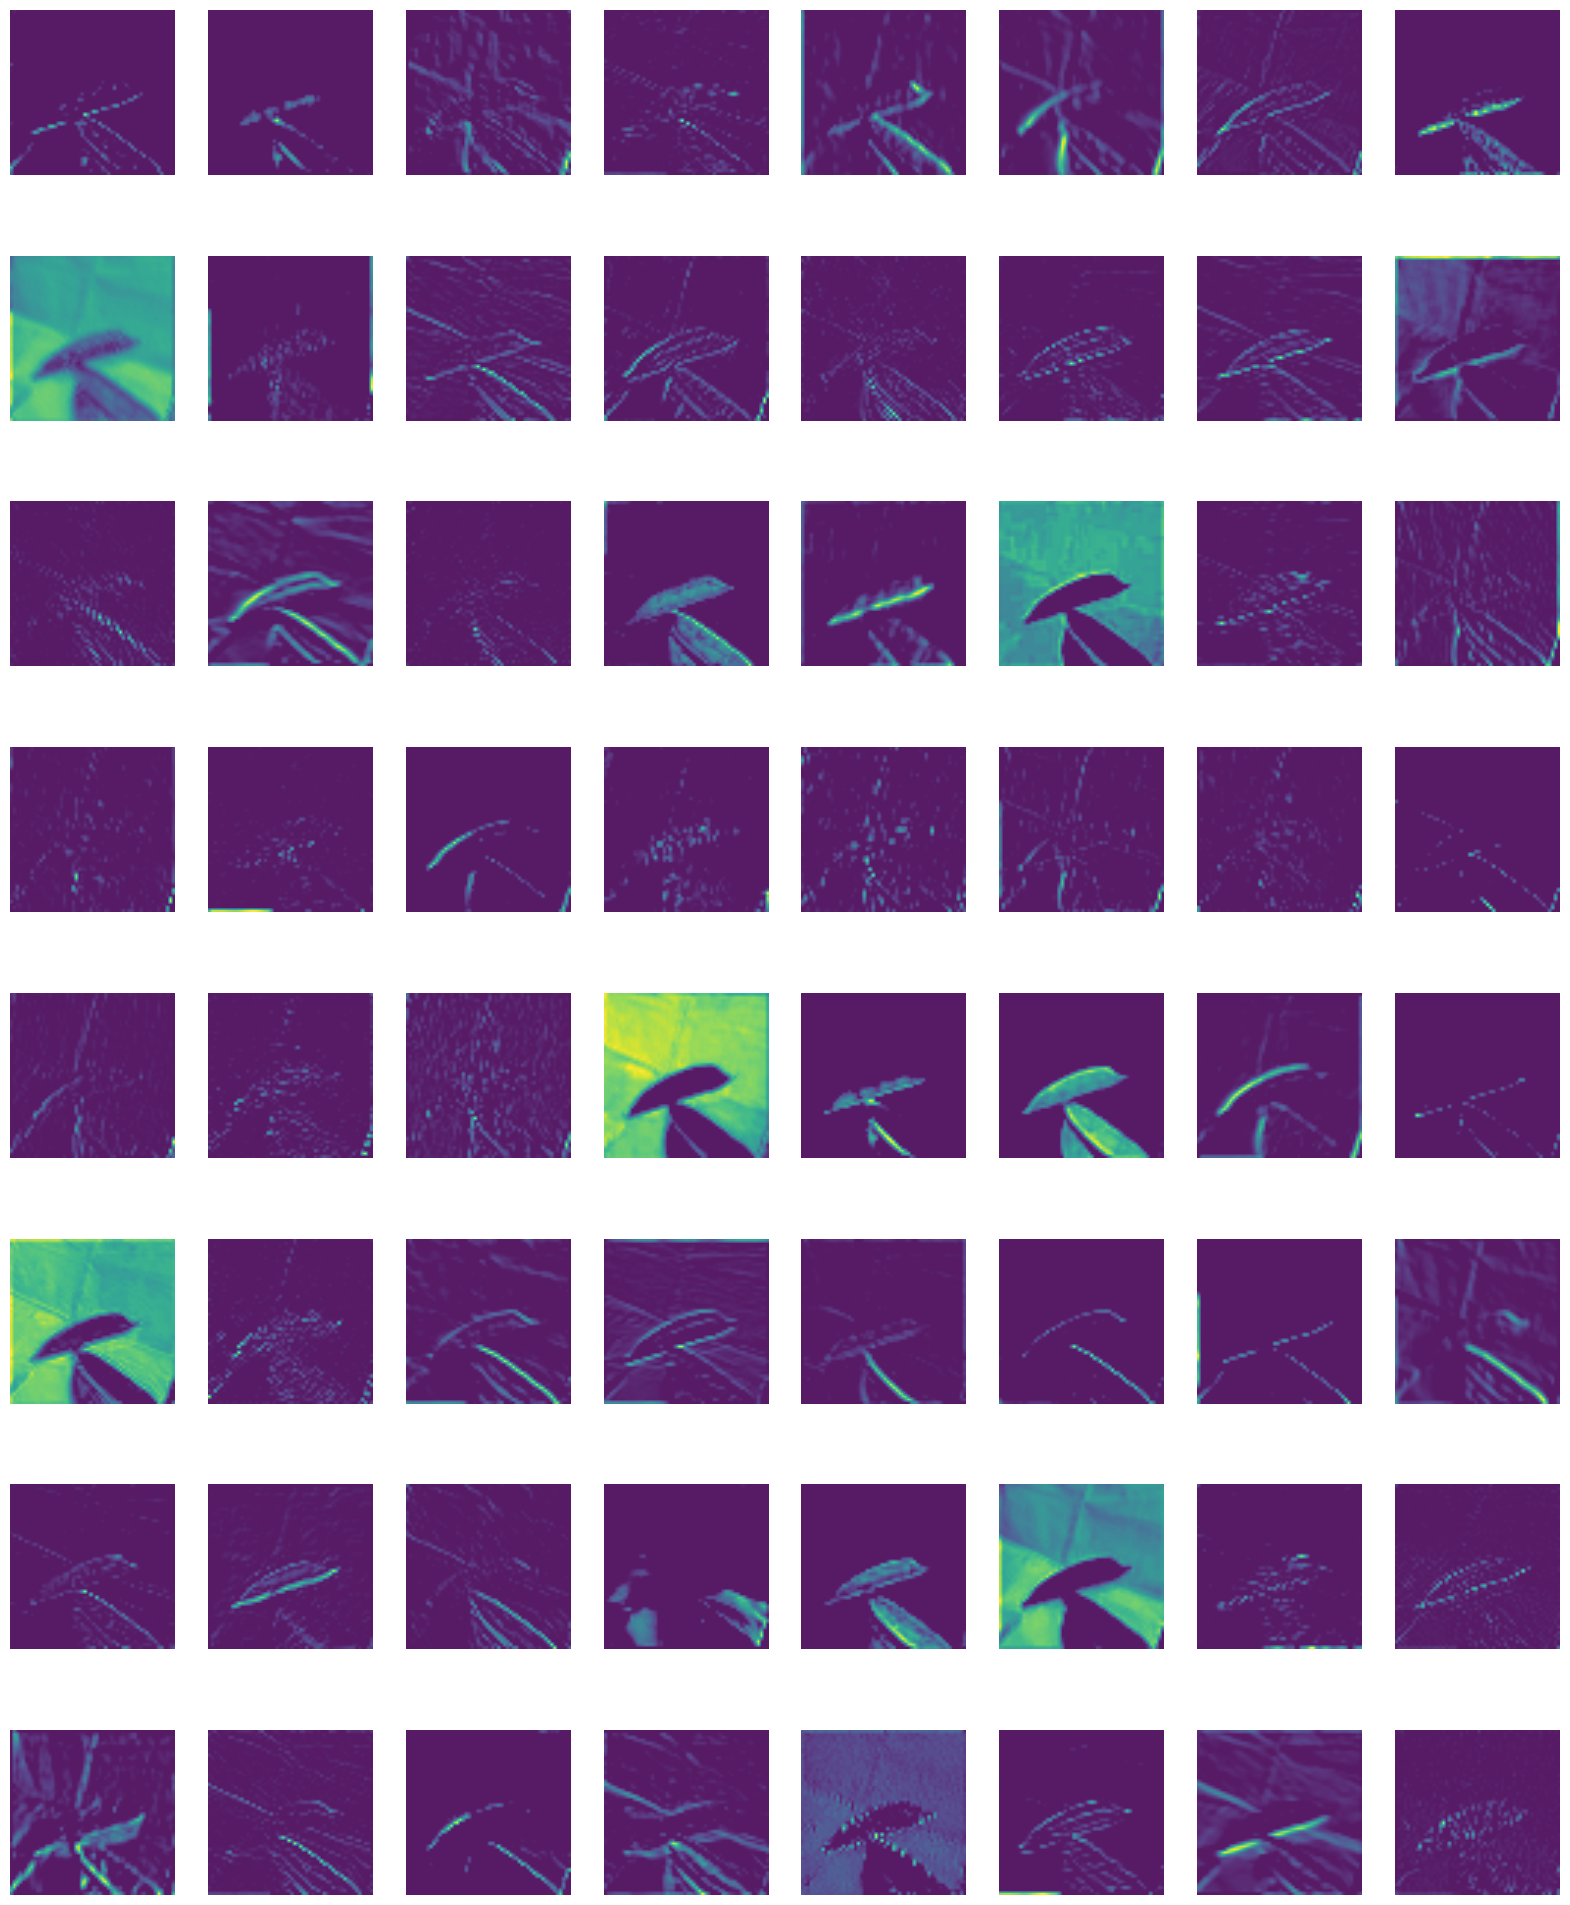

In [106]:

image_path = "../data/test/0028.jpg"  
input_image = preprocess_image(image_path)



cnn = 'cnn_0'
alexnet_children = list(alexnet.children())
alexnet_children[0][0].register_forward_hook(get_activation(cnn))


with torch.no_grad():
    output = alexnet(input_image)
print(np.shape(activation[cnn]))

num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 25))

dimensi_iter = activation[cnn][0,:,:,:].size(dim=0)
for i in range(dimensi_iter):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(activation[cnn][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
    plt.axis('off')


plt.show()





In [113]:
def show_features(model, image_path, num_rows, num_cols):
    input_image = preprocess_image(image_path)
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    cnn = 'cnn_0'
    model_children = list(model.children())
    model_children[0][0].register_forward_hook(get_activation(cnn))


    with torch.no_grad():
        output = model(input_image)
    print(np.shape(activation[cnn]))

    

    plt.figure(figsize=(20, 25))

    dimensi_iter = activation[cnn][0,:,:,:].size(dim=0)
    for i in range(dimensi_iter):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(activation[cnn][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
        plt.axis('off')
        plt.title(i + 1)


    plt.show()

    


torch.Size([1, 64, 56, 56])


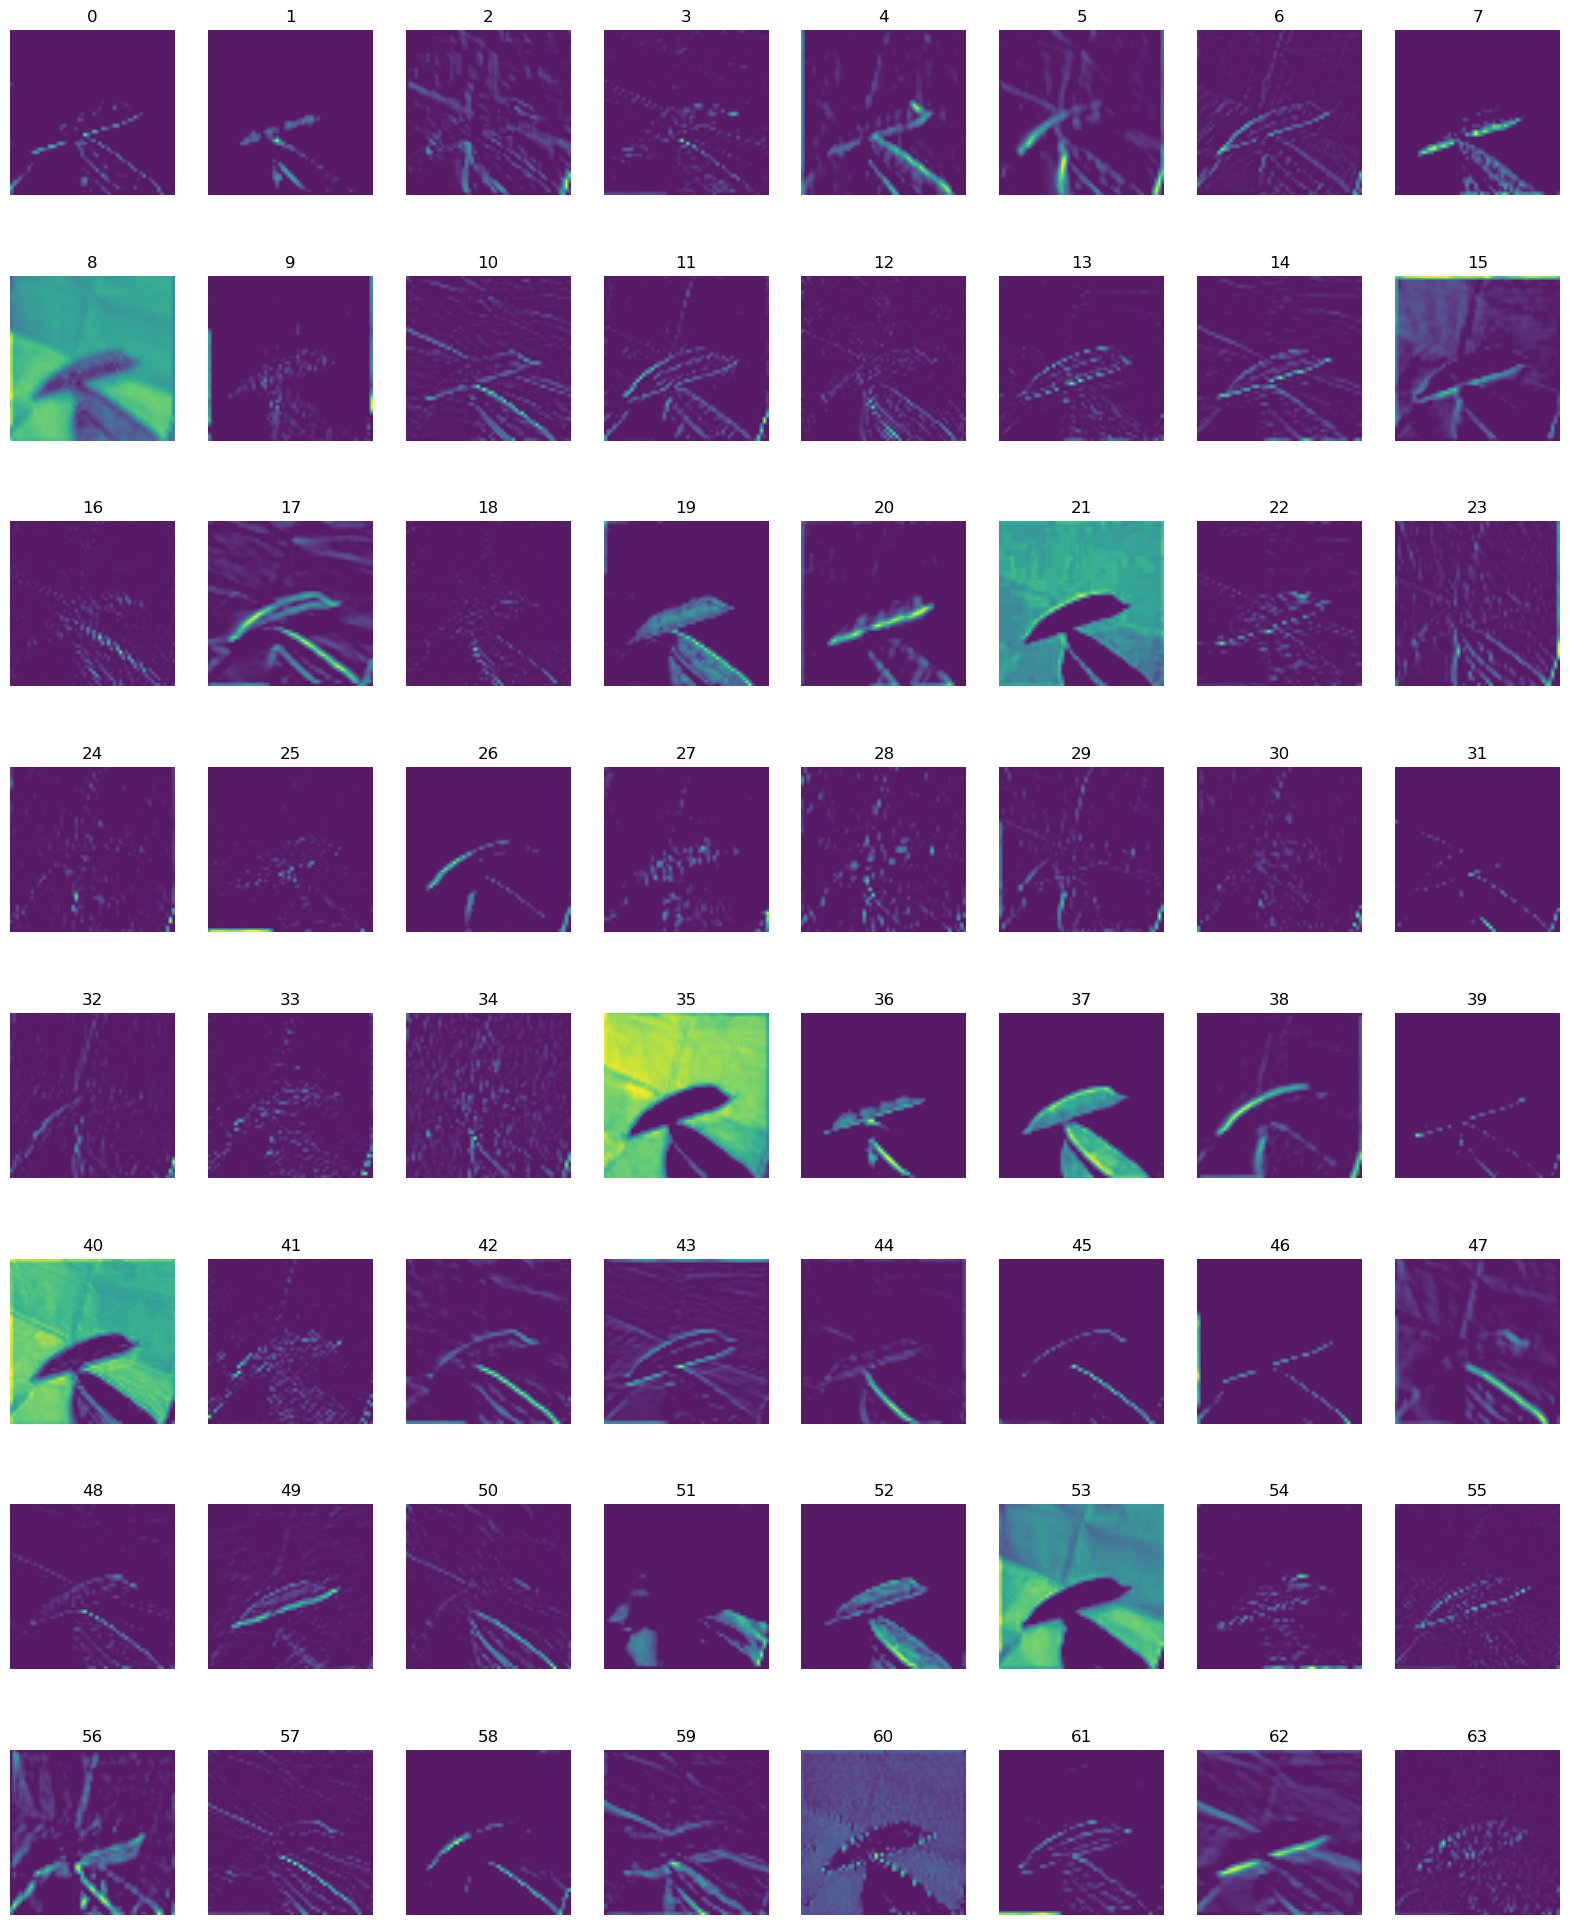

In [114]:
show_features(alexnet, "../data/test/0028.jpg", 8, 8)

torch.Size([1, 64, 227, 227])


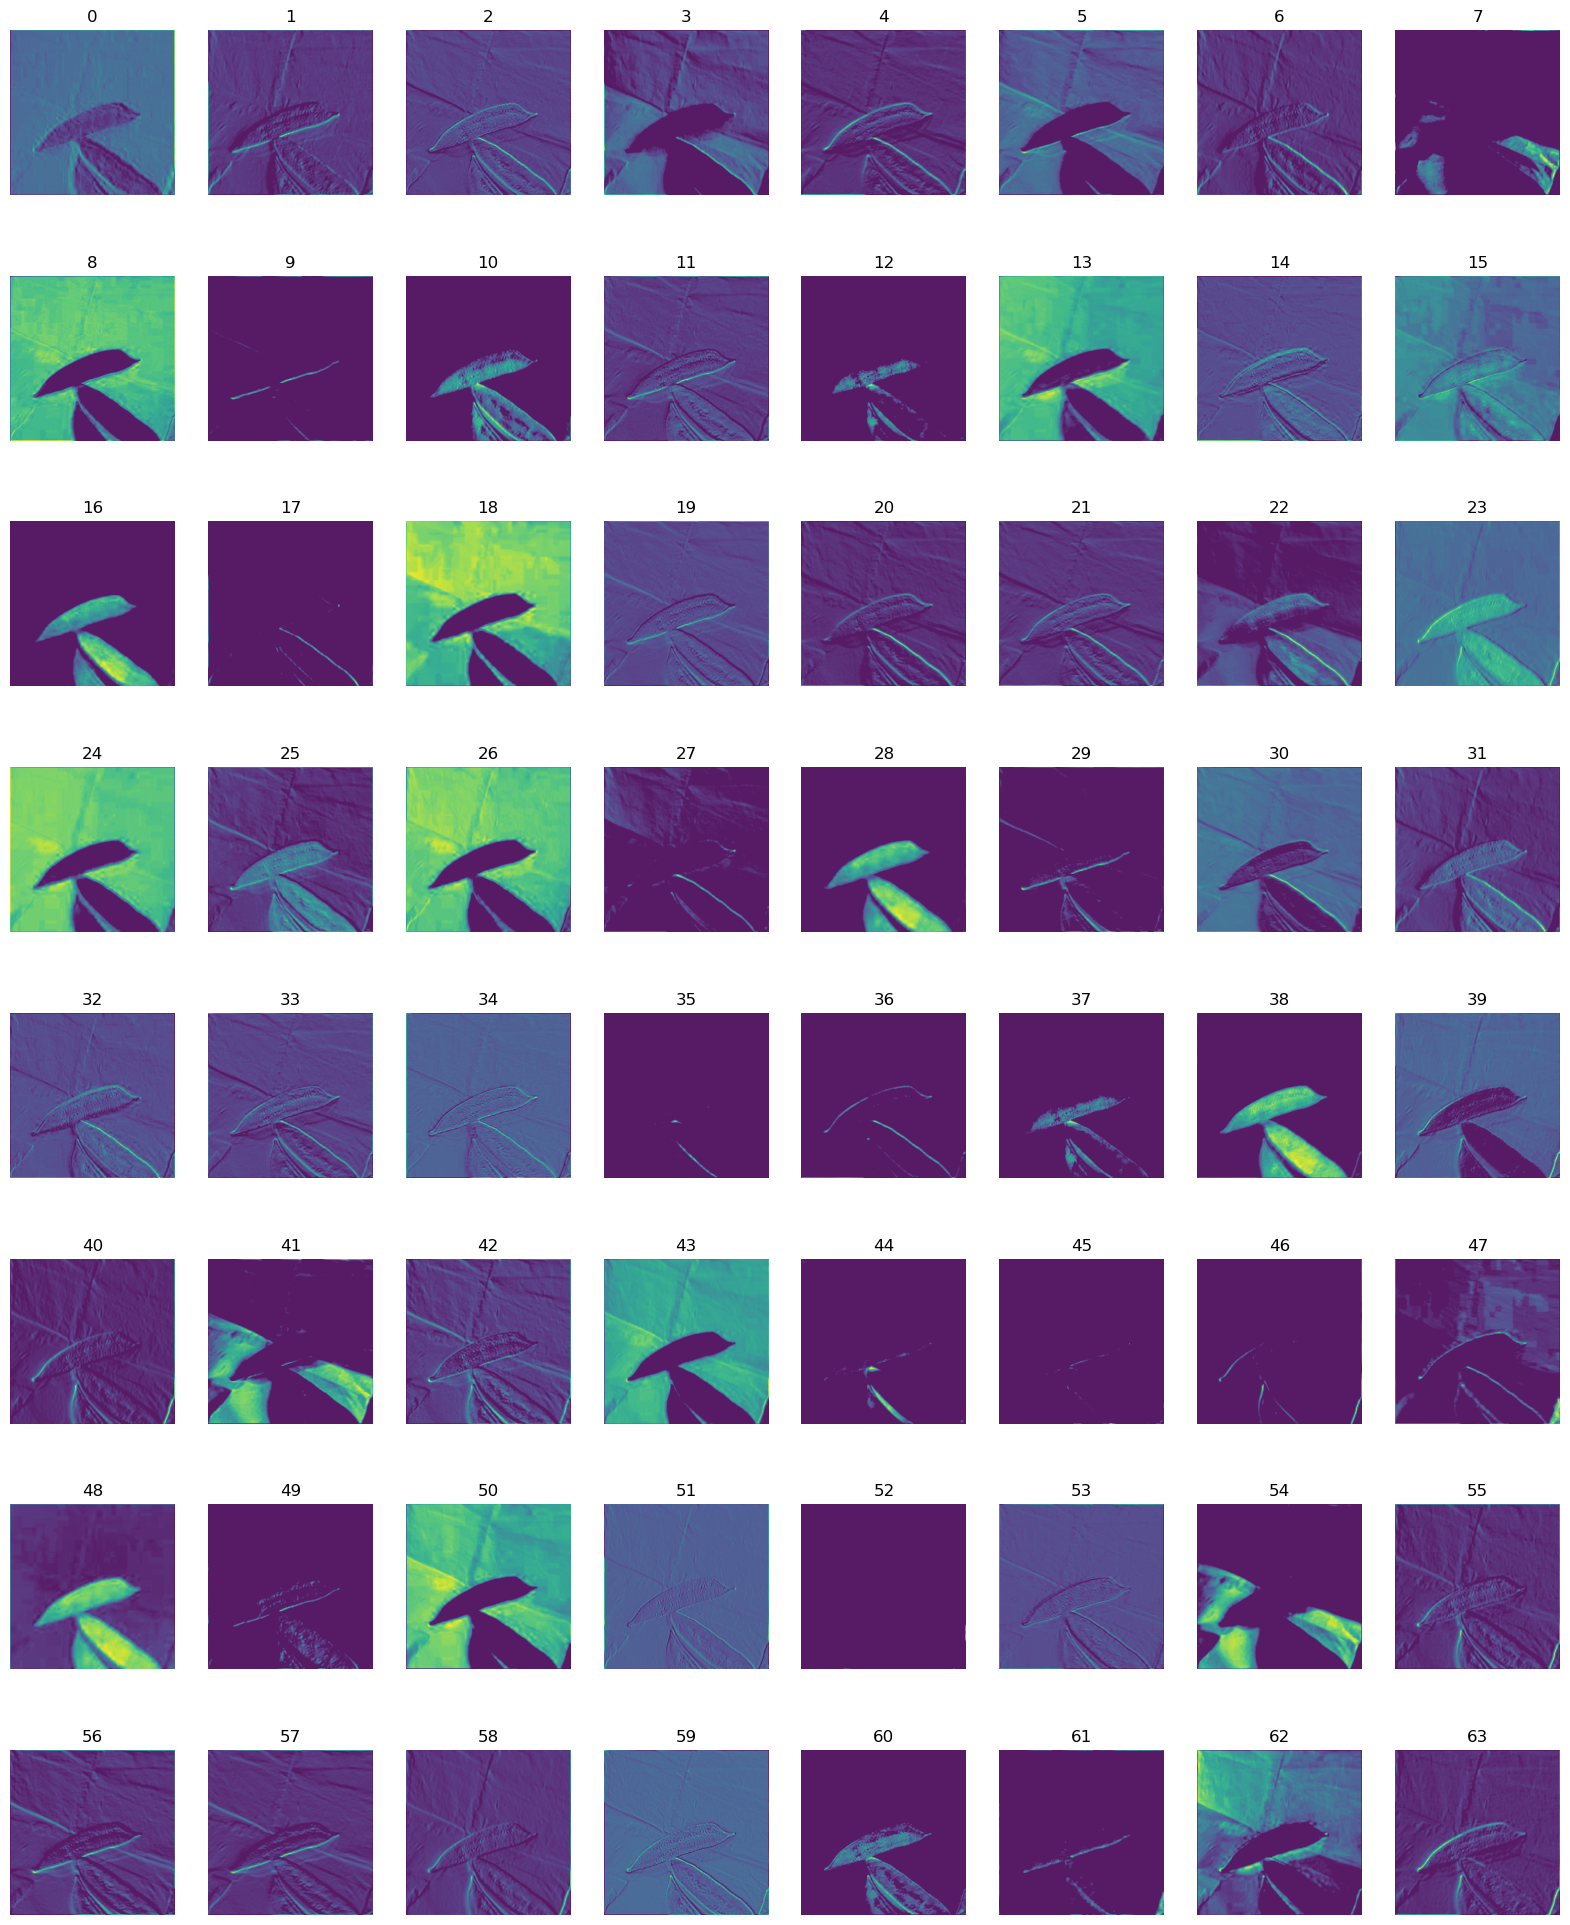

In [115]:
show_features(vgg16, "../data/test/0028.jpg", 8, 8)